In [87]:
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Estadísticos
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy import stats


# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [88]:
df = pd.read_csv("../archivos/cod_bikes.csv", index_col = 0)
df.head()

,estacion,año,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,dia_semana_domingo,dia_semana_jueves,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
0,0,0,1,14.110847,80.5833,10.749882,331,654,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,14.902598,69.6087,16.652113,131,670,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,8.050924,43.7273,16.636703,120,1229,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,8.200000,59.0435,10.739832,108,1454,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,9.305237,43.6957,12.522300,82,1518,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
df.drop(['clientes_casuales', 'estacion'], axis=1,inplace=True)

In [90]:
df.head()

,año,dias_festivos,temperatura,humedad,velocidad_viento,clientes_registrados,dia_semana_domingo,dia_semana_jueves,dia_semana_lunes,dia_semana_martes,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
0,0,1,14.110847,80.5833,10.749882,654,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,14.902598,69.6087,16.652113,670,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,8.050924,43.7273,16.636703,1229,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,8.200000,59.0435,10.739832,1454,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,9.305237,43.6957,12.522300,1518,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
X = df.drop("clientes_registrados", axis = 1)
y = df["clientes_registrados"]

In [92]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [93]:
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [94]:
max_features = np.sqrt(len(x_train.columns))
max_features

4.898979485566356

In [95]:
print(arbol.tree_.max_depth)

20


In [96]:
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [97]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [98]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,534.719178,641220.157534,800.762235,0.702942,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I


In [99]:
param = {"max_depth": [4,8,10], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 20, 50,100],
        "min_samples_leaf": [5,10, 20,50]} 

In [100]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") 

In [101]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 8, 10], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'min_samples_split': [10, 20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [102]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=10, max_features=4, min_samples_leaf=5,
                      min_samples_split=10)

In [103]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [104]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree enc regis")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,738.606226,883882.894708,940.150464,0.590524,test,Decision tree enc regis
1,634.326703,679143.733667,824.101774,0.727589,train,Decision tree enc regis


In [105]:
dt_results2.to_csv('../archivos/dt_enc_regis.csv')

In [106]:

# vamos a crearnos un dataframe 
importancia_predictores_esta = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores_esta.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores_esta


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,temperatura,0.363159
0,año,0.312776
4,velocidad_viento,0.090801
13,mes_2,0.078366
3,humedad,0.064295
7,dia_semana_lunes,0.022207
22,mes_11,0.021995
12,mes_1,0.012495
11,dia_semana_viernes,0.008897
10,dia_semana_sabado,0.008039


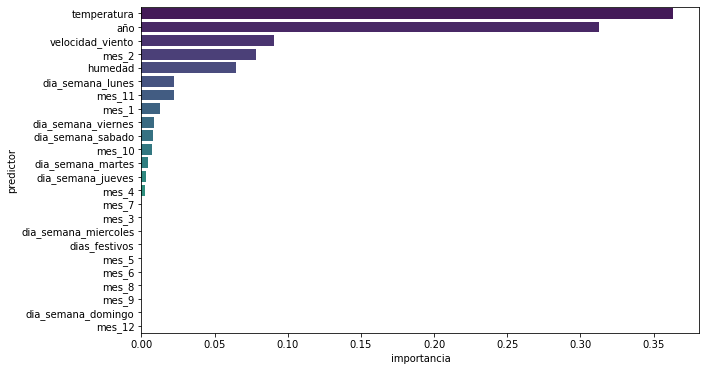

In [107]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores_esta, palette="viridis");
plt.show()